In [ ]:
import re
import string
import pickle

import statistics
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer


import ssl

from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.layers import LSTM, Dense, Dropout, Embedding, Dense, Embedding, LSTM, SpatialDropout1D, GlobalMaxPooling1D, Dropout, Bidirectional
from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import regularizers
import tensorflow as tf


In [ ]:
train = pd.read_csv("datasets/train_data.csv")

train.head()

,Unnamed: 0.1,Unnamed: 0,index,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment,tokens,tokens_lemmatize,comment_clean
0,0,487743,316349,1,easy i would tell a cop i am scared of gun dea...,Iamsuperimposed,worldnews,1,1,0,2016-07,2016-07-22 18:21:42,One anecdote about a friend of a guy in a coun...,"['easy', 'would', 'tell', 'cop', 'scared', 'gu...","['easy', 'would', 'tell', 'cop', 'scar', 'gun'...",easy would tell cop scar gun deal black market...
1,1,137681,285487,0,way better than getting a case of the cletus,dropitlikeitshot,pics,69,69,0,2016-06,2016-06-08 03:38:43,Gettin' more Cooter than he can handle?,"['way', 'better', 'getting', 'case', 'cletus']","['way', 'better', 'get', 'case', 'cletus']",way better get case cletus
2,2,93543,129476,0,always know you have other exits,secretgspot,2meirl4meirl,1,1,0,2016-09,2016-09-19 05:46:09,2meirl4meirl,"['always', 'know', 'exits']","['always', 'know', 'exit']",always know exit
3,3,603009,793028,1,yeah but maybe you re just in denial,meldolphin,TrollXChromosomes,2,2,0,2014-07,2014-07-02 21:06:38,Exactly... and if you question that or argue w...,"['yeah', 'maybe', 'denial']","['yeah', 'maybe', 'denial']",yeah maybe denial
4,4,361245,990928,0,looks like you re hopping on the bandwagon too,Dark-Castle,funny,1,1,0,2013-12,2013-12-07 17:09:15,"Hey reddit, I just lost 15 pounds and I'm keep...","['looks', 'like', 'hopping', 'bandwagon']","['look', 'like', 'hop', 'bandwagon']",look like hop bandwagon


In [ ]:
validation = pd.read_csv("datasets/validation_data.csv")

In [ ]:
test = pd.read_csv("datasets/test_data.csv")

test.head()

,Unnamed: 0.1,Unnamed: 0,label,comment,score,ups,downs,date,tokens,tokens_lemmatize,comment_clean
0,0,0,0,welcome to college gameday where a college kid...,102,-1,-1,2016-10,"['welcome', 'college', 'gameday', 'college', '...","['welcome', 'college', 'gameday', 'college', '...",welcome college gameday college kid make brill...
1,1,1,0,didn t name the character taylor swiftcast 1 10,89,-1,-1,2016-10,"['name', 'character', 'taylor', 'swiftcast', '...","['name', 'character', 'taylor', 'swiftcast', '...",name character taylor swiftcast 1 10
2,2,2,0,the convention just got a lot less interesting,119,119,0,2016-07,"['convention', 'got', 'lot', 'less', 'interest...","['convention', 'get', 'lot', 'less', 'interest']",convention get lot less interest
3,3,3,0,and its happening right in front of me,78,78,0,2014-09,"['happening', 'right', 'front']","['happen', 'right', 'front']",happen right front
4,4,4,1,yeah man i really can t stand this 70 degree w...,96,96,0,2012-12,"['yeah', 'man', 'really', 'stand', '70', 'degr...","['yeah', 'man', 'really', 'stand', '70', 'degr...",yeah man really stand 70 degree weather


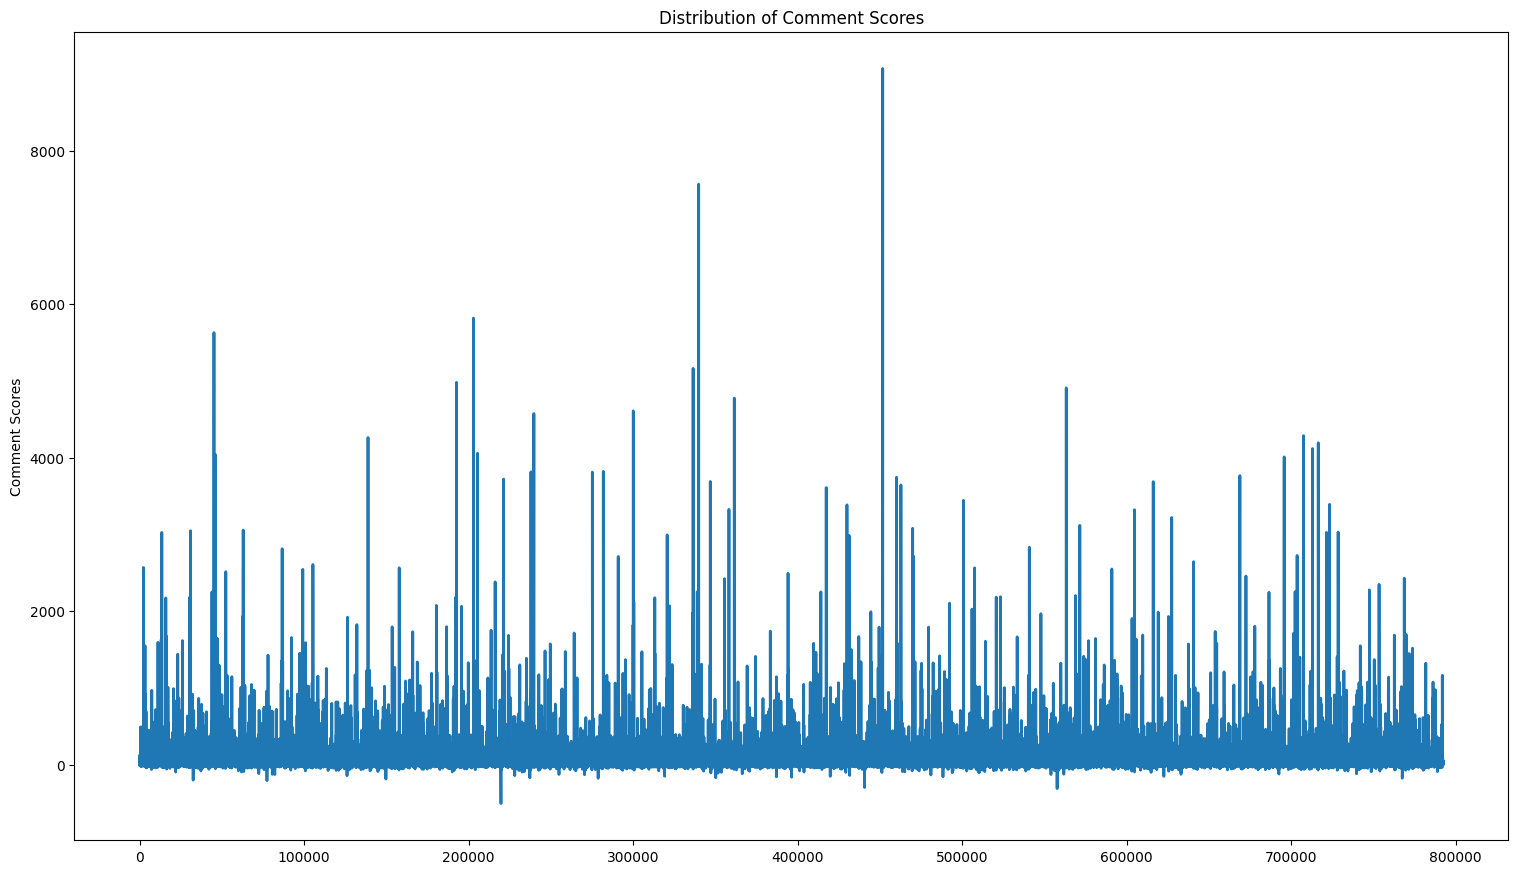

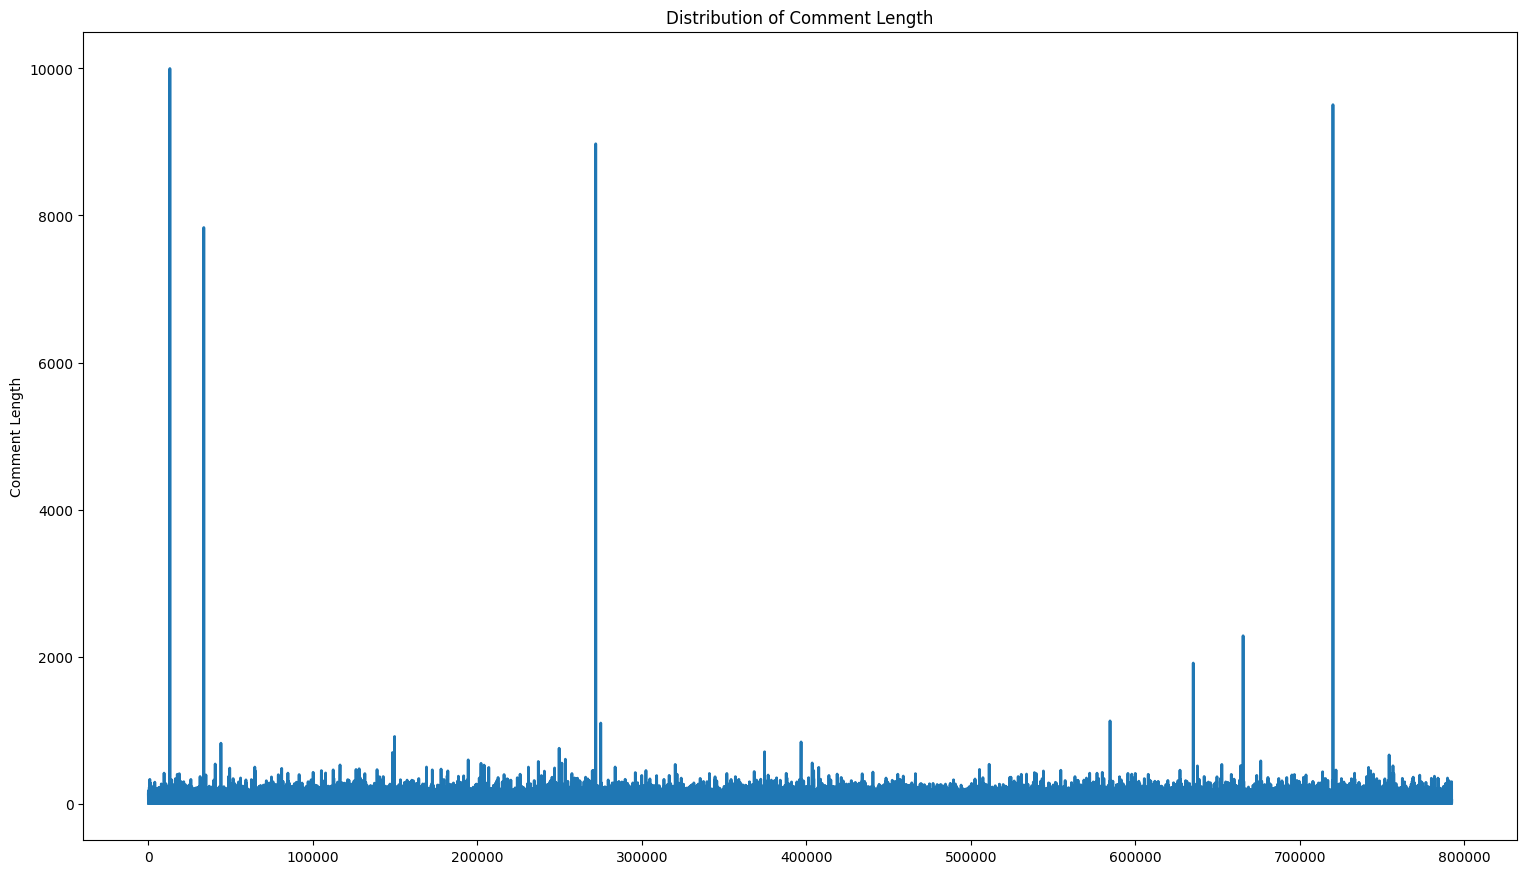

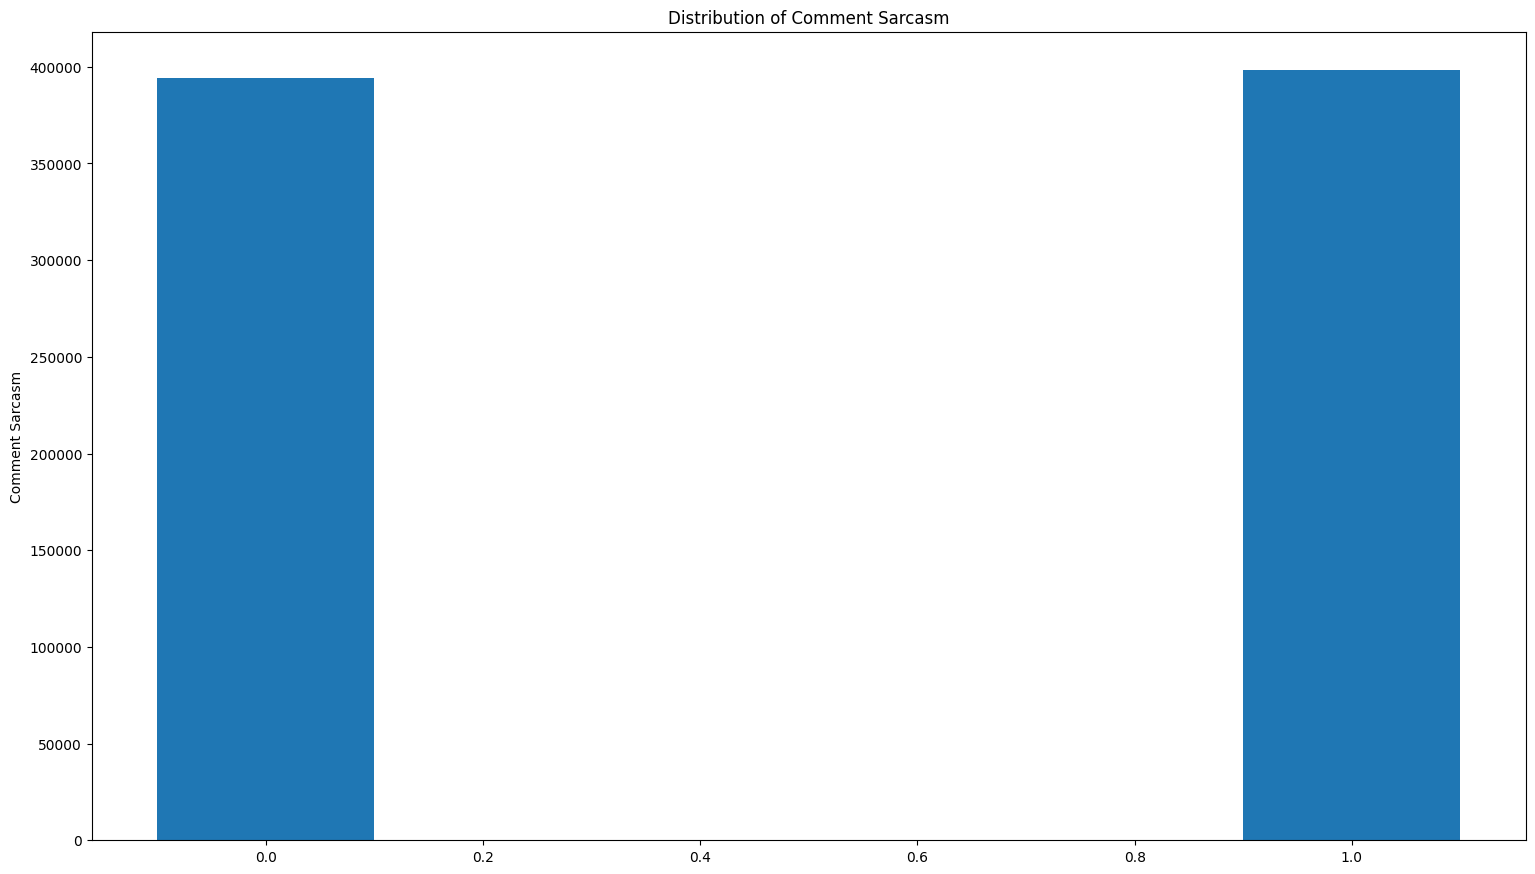

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)

scores_arr = train["score"].values.tolist()

#Score Distribution
ax.plot(range(1, len(scores_arr)+1),scores_arr, linewidth=2.0)

plt.title("Distribution of Comment Scores")
plt.ylabel("Comment Scores")

plt.show()

#Comment Distribution
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)

len_vec_fn = np.vectorize(lambda x : len(str(x)))

comment_length = len_vec_fn(train["comment"])

ax.plot(range(1, len(comment_length)+1),comment_length, linewidth=2.0)

plt.title("Distribution of Comment Length")
plt.ylabel("Comment Length")

plt.show()

#Sarcasm Distribution
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)

label_0 = len(train.loc[train["label"] == 0])
label_1 = len(train.loc[train["label"] == 1])

plt.bar([0, 1], [label_0, label_1], width=0.2)


plt.title("Distribution of Comment Sarcasm")
plt.ylabel("Comment Sarcasm")

plt.show()

In [ ]:
# Fill missing or null values with an empty string
train['comment'] = train['comment'].fillna('')

# Remove non-alphanumeric characters and convert to lowercase
train['comment'] = train['comment'].astype(str).apply(lambda x: re.sub(r'\W+', ' ', x.lower()))
validation["comment"] = validation['comment'].astype(str).apply(lambda x: re.sub(r'\W+', ' ', x.lower()))
test["comment"] = test['comment'].astype(str).apply(lambda x: re.sub(r'\W+', ' ', x.lower()))

In [ ]:
#Download required nltk libraries
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/sushantbelsare/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sushantbelsare/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/sushantbelsare/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/sushantbelsare/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [ ]:
# Tokenize the comments
train['tokens'] = train['comment'].apply(lambda x: word_tokenize(x))
validation['tokens'] = validation['comment'].apply(lambda x: word_tokenize(x))
test['tokens'] = test['comment'].apply(lambda x: word_tokenize(x))

In [ ]:
# Remove stop words from the tokens
stop_words = set(stopwords.words('english'))
train['tokens'] = train['tokens'].apply(lambda x: [token for token in x if token not in stop_words])
validation['tokens'] = validation['tokens'].apply(lambda x: [token for token in x if token not in stop_words])
test['tokens'] = test['tokens'].apply(lambda x: [token for token in x if token not in stop_words])

In [ ]:
lem = WordNetLemmatizer()
#Convert tokens into their base roots using lammetization
train['tokens_lemmatize'] = train['tokens'].apply(lambda x: [lem.lemmatize(word, "v") for word in x])
train['comment_clean'] = train['tokens_lemmatize'].apply(lambda x: ' '.join([w for w in x if w not in string.punctuation]))

validation['tokens_lemmatize'] = validation['tokens'].apply(lambda x: [lem.lemmatize(word, "v") for word in x])
validation['comment_clean'] = validation['tokens_lemmatize'].apply(lambda x: ' '.join([w for w in x if w not in string.punctuation]))

test['tokens_lemmatize'] = test['tokens'].apply(lambda x: [lem.lemmatize(word, "v") for word in x])
test['comment_clean'] = test['tokens_lemmatize'].apply(lambda x: ' '.join([w for w in x if w not in string.punctuation]))

In [ ]:
#Save Progress as a checkpoint
train.to_csv("train-lemmatized.csv", sep=',')
validation.to_csv("validation-lemmatized", sep=',')
test.to_csv("test-balanced-lemmatized",sep=",")

In [ ]:
#Create a tokenizer for Keras embedding
max_features = 20000
oov_token = '<00V>'
tokenizer = Tokenizer(num_words=max_features, oov_token=oov_token)
tokenizer.fit_on_texts(train['comment_clean'])

In [ ]:
train = train.loc[train['comment_clean'].str.len() <= 100]
split_data = np.array_split(train, 10)

In [ ]:
max_features = 20000
def create_model(input_vec):

    embed_dim = 128 #Embedded dimensions for the output of Embedding layer
    lstm_out = 32 #Output shape of LSTM layer

    model = Sequential()
    model.add(Embedding(max_features, embed_dim,input_length = input_vec.shape[1])) #Create vectors from tokenized sentences
    model.add(SpatialDropout1D(0.4)) #Drop 40% values spatially to avoid overfitting
    model.add(LSTM(lstm_out, dropout= 0.2, recurrent_dropout= 0.2, return_sequences=True)) #LSTM with horizontal and vertical dropouts
    model.add(GlobalMaxPooling1D()) #Max pooling
    model.add(Dense(16, activation="relu")) #Dense layer of 16 neurons with relu activation
    model.add(Dropout(0.4, seed=10)) #Drop random 40% values with a seed of 10
    model.add(Dense(1,activation='sigmoid')) #Predict label as a probablity between 0 and 1
    model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy']) #Compile using binary_crossentropy since it's two class classification

    return model

In [ ]:
create_model(np.array([[0 for i in range(0, 60)]])).summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 60, 128)           2560000   
                                                                 
 spatial_dropout1d (SpatialD  (None, 60, 128)          0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 60, 32)            20608     
                                                                 
 global_max_pooling1d (Globa  (None, 32)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 16)                528       
                                                                 
 dropout (Dropout)           (None, 16)               

In [ ]:

max_len = 60 #Set the maximum length of a sequence
padding_type = 'post' #Pad after each sequence
trunc_type = 'post' #Truncate after each sequence

model_configurations = {} #Create a dictionary for storing model configurations

#Iterate over 10 chunks of training dataset and create models
for i in range(0,10):
    #Tokenize training data and format uniformally using padding
    X_train = tokenizer.texts_to_sequences(split_data[i]['comment_clean'].astype(str).values)
    X_train = pad_sequences(X_train, maxlen=max_len, padding=padding_type, truncating=trunc_type)
    Y_train= split_data[i]['label'].values

    #Set the batch size to 32
    batch_size = 32

    rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2) #Reduce learning rate if loss doesn't change
    es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=10) #Stop training if loss doesn't improve
    #Save model when it's performing well
    mc = ModelCheckpoint('models/rnn_model_{}.h5'.format(i+1), verbose=1, save_freq="epoch", mode='max', monitor='val_accuracy', save_best_only=True)

    #Fetch model
    model = create_model(X_train)

    #Train the model with 25 epochs and 32 batch size per epoch
    with tf.device("cpu:0"):
        model.fit(X_train, Y_train, epochs = 25, batch_size=batch_size, verbose = 2, callbacks=[es, mc, rlrp])
        model.save("models/new_rnn_model_{}".format(i+1))

    #Store the configuration of each model in a dictionary
    model_configurations["model_{}".format(i+1)] = {"train_X_shape" : X_train.shape, "train_Y_shape": Y_train.shape,
                                                    "tokenizer": tokenizer}

#Save configurations for validation and prediction
pickle.dump(model_configurations, open("models/rnn_model_configurations.p", "wb"))

Epoch 1/25

Epoch 1: val_accuracy improved from -inf to 0.55800, saving model to 3_May_rnn_model_1.h5
16/16 - 43s - loss: 0.7387 - accuracy: 0.5130 - val_loss: 0.7357 - val_accuracy: 0.5580 - lr: 0.0010 - 43s/epoch - 3s/step
Epoch 2/25

Epoch 2: val_accuracy improved from 0.55800 to 0.60400, saving model to 3_May_rnn_model_1.h5
16/16 - 36s - loss: 0.7326 - accuracy: 0.5535 - val_loss: 0.7270 - val_accuracy: 0.6040 - lr: 0.0010 - 36s/epoch - 2s/step
Epoch 3/25

Epoch 3: val_accuracy improved from 0.60400 to 0.63500, saving model to 3_May_rnn_model_1.h5
16/16 - 30s - loss: 0.7218 - accuracy: 0.5829 - val_loss: 0.7102 - val_accuracy: 0.6350 - lr: 0.0010 - 30s/epoch - 2s/step
Epoch 4/25

Epoch 4: val_accuracy improved from 0.63500 to 0.64700, saving model to 3_May_rnn_model_1.h5
16/16 - 28s - loss: 0.7060 - accuracy: 0.5978 - val_loss: 0.6877 - val_accuracy: 0.6470 - lr: 0.0010 - 28s/epoch - 2s/step
Epoch 5/25

Epoch 5: val_accuracy improved from 0.64700 to 0.65700, saving model to 3_May_r

In [ ]:
#Load models and configurations from stored files
models = []
for i in range(0, 10):
    models.append(load_model("model/rnn_model_{}.h5".format(i+1)))

model_configurations = pickle.load(open("model/rnn_model_configurations.p", "rb"))

In [ ]:
tp, tn, fp, fn = 0, 0, 0, 0 #Initialize variables

#Iterate over each row of validation dataset
for index, row in validation.iterrows():
    #Tokenize comment
    sentiments = []
    comment = [row['comment_clean']]
    tokens = tokenizer.texts_to_sequences(comment)
    #Iterate over each model
    for i in range(1, 11):
        #Pad tokenized comment based on the layer_0 of each model
        X_shape = model_configurations["model_{}".format(i)]["train_X_shape"][1]
        tokens = pad_sequences(tokens, maxlen= X_shape)

        #Store the prediction of each model in a list
        sentiments.append(round(models[i-1].predict(tokens, batch_size=1,verbose = 0).tolist()[0][0]))
    #Find the prediction using mode
    sentiment = statistics.mode(sentiments)

    #Set TruePositive, TrueNegative, FalsePositive and FalseNegative based on the prediction
    if sentiment == row['label']:
        if sentiment == 1:
            tp += 1
        else:
            tn += 1
    else:
        if sentiment == 1:
            fp += 1
        else:
            fn += 1


In [ ]:
precision = tp/(tp + fp) #Calculate precision using formula

recall = tp/(tp + fn) #Calculate recall using formula

F_1 = (2 * precision * recall)/(precision + recall) #Calculate F-1 score using formula

accuracy = (tp + tn)/(tp + tn + fp + fn) #Calculate accuracy using formula

print("The Precision is {}".format(precision))
print("The Recall is {}".format(recall))
print("The F-1 score is {}".format(F_1))
print("The Accuracy is {}".format(accuracy))

print("\nTrue Positives: {}".format(tp))
print("False Positives: {}".format(fp))
print("True Negatives: {}".format(tn))
print("False Negatives: {}".format(fn))

The Precision is 0.747072599531616
The Recall is 0.7824106517168886
The F-1 score is 0.7643333903816533
The Accuracy is 0.8333434190620272

True Positives: 4466
False Positives: 1512
True Negatives: 9305
False Negatives: 1242


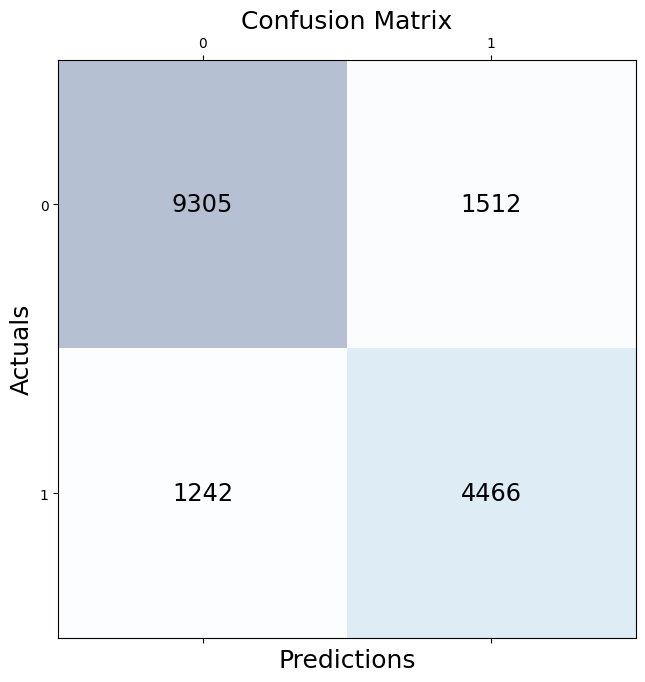

In [ ]:
#Draw confusion matrix
conf_matrix = np.array([np.array([tn, fp]),np.array([fn, tp])])
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [ ]:
#Predict the sentiment of test dataset using 10 RNN models
sarcastic = 0
non_sarcastic = 0
for index, row in test.iterrows():
    sentiments = []
    for i in range(1, 11):
        comment = [row['comment_clean']]
        tokenizer = model_configurations["model_{}".format(i)]["tokenizer"]
        X_shape = model_configurations["model_{}".format(i)]["train_X_shape"][1]
        tokens = tokenizer.texts_to_sequences(comment)
        tokens = pad_sequences(tokens, maxlen= X_shape)

        sentiments.append(round(models[i-1].predict(tokens, batch_size=1,verbose = 0).tolist()[0][0]))
    sentiment = statistics.mode(sentiments)

    if sentiment == 1:
        sarcastic += 1
    else:
        non_sarcastic += 1

/var/folders/y6/dyxff58n3j30dt9r_77l12gm0000gn/T/ipykernel_95306/1924726734.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_popular["comment_snowball"] = test_popular["tokens"].astype(str).apply(lambda x: ' '.join([snowball.stem(word) for word in word_tokenize(x)]))


In [ ]:
sarcastic = 22752
non_sarcastic = 46102

In [ ]:
print("Total number of sarcastic comments based on prediction {}".format(sarcastic))
print("Total number of non-sarcastic comments based on prediction {}".format(non_sarcastic))
print("Percentage of sarcastic comments based on prediction {}".format((sarcastic * 100)/(sarcastic + non_sarcastic)))

Total number of sarcastic comments based on prediction 22752
Total number of non-sarcastic comments based on prediction 46102
Percentage of sarcastic comments based on prediction 33.04383187614373
